# Random Forest 

Copyright @ 2020 **ABCOM Information Systems Pvt. Ltd.** All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.

In [ ]:
from random import randrange
import pandas as pd
import math
from math import sqrt
import seaborn as sns 
import matplotlib.pyplot as plt

# Loading data

In [ ]:
!wget https://raw.githubusercontent.com/abcom-mltutorials/Random-Forest/master/datasets_727551_1263738_heart_failure_clinical_records_dataset.csv

--2020-11-13 04:30:44--  https://raw.githubusercontent.com/abcom-mltutorials/Random-Forest/master/datasets_727551_1263738_heart_failure_clinical_records_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4257 (4.2K) [text/plain]
Saving to: ‘datasets_727551_1263738_heart_failure_clinical_records_dataset.csv’

datasets_727551_126 100%[===================>]   4.16K  --.-KB/s    in 0s      

2020-11-13 04:30:44 (61.6 MB/s) - ‘datasets_727551_1263738_heart_failure_clinical_records_dataset.csv’ saved [4257/4257]



In [ ]:
dset = pd.read_csv("datasets_727551_1263738_heart_failure_clinical_records_dataset.csv")

# Describing dataset

In [ ]:
dset.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
dset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,63.673267,0.485149,547.138614,0.445545,36.633663,0.445545,262942.794752,1.572871,136.237624,0.663366,0.326733,45.752475,0.653465
std,12.844539,0.502272,1274.032527,0.499505,13.329458,0.499505,85585.736145,1.261770,4.688600,0.474915,0.471358,26.712321,0.478239
min,41.000000,0.000000,23.000000,0.000000,14.000000,0.000000,47000.000000,0.600000,116.000000,0.000000,0.000000,4.000000,0.000000
25%,55.000000,0.000000,94.000000,0.000000,25.000000,0.000000,210000.000000,1.000000,134.000000,0.000000,0.000000,23.000000,0.000000
50%,63.000000,0.000000,160.000000,0.000000,35.000000,0.000000,263358.030000,1.180000,137.000000,1.000000,0.000000,43.000000,1.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,310000.000000,1.830000,140.000000,1.000000,1.000000,73.000000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,497000.000000,9.400000,146.000000,1.000000,1.000000,87.000000,1.000000


# Understanding correlation between features

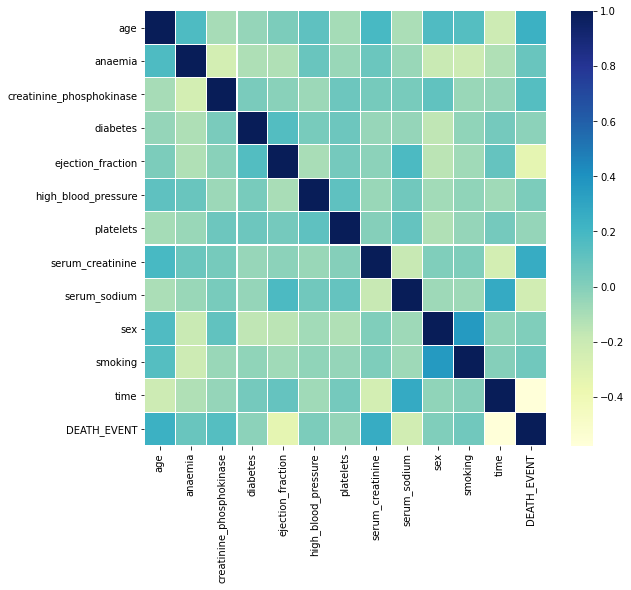

In [ ]:
corrmat = dset.corr()   
f, ax = plt.subplots(figsize =(9, 8)) 
cg = sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 
cg

In [ ]:
# convert to Python list
dset = dset.values.tolist()

# Utility functions

## Splitting dataset

In [ ]:
def testsplit(index, value, dset):
	left, right = list(), list()
	for row in dset:
		if row[index] > value:
			right.append(row)
		else:
			left.append(row)
	return left, right

## Class count


In [ ]:
def class_counts(group):
    counts = {}  
    for row in group:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

## Entropy

In [ ]:
def entropy(group):
    entries = class_counts(group)
    avg_entropy = 0
    size = float(len(group))
    for label in entries:
        prob = entries[label] / size
        avg_entropy = (avg_entropy 
                  + (prob * math.log(prob, 2)))
    return -1*avg_entropy



## Group Entropy

In [ ]:
def Entropy_Groups(groups, classes):
  n_instances = float(sum([len(group) for group in groups]))
  Entropy = 0.0
  for group in groups:
    size = float(len(group))
    Entropy_group = entropy(group)
    Entropy += (Entropy_group) * (size / n_instances)
  return Entropy

## Split

In [ ]:
def get_split(dset, number_of_features):
  classval = list(set(row[-1] for row in dset))
  updated_index = 500
  split_value = 500
  score = 1
  split_groups = None
  features = list()
  while len(features) < number_of_features:
    index = randrange(len(dset[0])-1)
    if index not in features:
       features.append(index)
  for index in features:
    for row in dset:
      groups = testsplit(index, row[index], dset)
      Entropy = Entropy_Groups(groups, classval)
      if Entropy < score:
        updated_index = index
        split_value = row[index]
        score = Entropy
        split_groups = groups
  return {'index':updated_index, 'value':split_value,
                     'groups':split_groups}

## The to_terminal function 
returns the class with highest number of elements in the group as output.







In [ ]:
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

## Tree termination

In [ ]:
def split(node, max_depth, min_size, 
                  number_of_features, depth):
  left, right = node['groups']
  del(node['groups'])
  # check for a no split
  if not left or not right:
    node['left'] =  to_terminal(left + right)
    node['right'] = to_terminal(left + right)
    return
 	# check for max depth
  if depth >= max_depth:
    node['left'] = to_terminal(left)
    node['right'] = to_terminal(right)
    return
  # process left child
  if len(left) <= min_size:
    node['left'] = to_terminal(left)
  else:
    node['left'] = get_split(left, number_of_features)
    split(node['left'], max_depth, min_size,
          number_of_features, depth+1)
	# process right child
  if len(right) <= min_size:
    node['right'] = to_terminal(right)
  else:
    node['right'] = get_split(right, number_of_features)
    split(node['right'], max_depth, min_size,
               number_of_features, depth+1)

## Build tree

In [ ]:
def build_tree(train, max_depth, min_size,
               number_of_features):
	root = get_split(train, number_of_features)
	split(root, max_depth, min_size, 
	      number_of_features, 1)
	return root

## Prediction

In [ ]:
def predict(node, row):
	if row[node['index']] > node['value']:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
	else:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']

In [ ]:
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

## Random forest implementation

In [ ]:
def random_forest(train, test, max_depth,
                  min_size,
                  n_trees, number_of_features):
	trees = list()
	for i in range(n_trees):
		train_set = list(train)
		tree = build_tree(train_set, max_depth, 
		               min_size, number_of_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) 
                      for row in test]
	return(predictions)

## Accuracy

In [ ]:
def accuracy_metric(actual, predicted):
	correct_prediction = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct_prediction += 1
	return correct_prediction / float(len(actual)) * 100.0

## Algorithm evaluation

In [ ]:
def algorithm_evaluation(dset, algorithm, n_folds, *args):
  dset_split = list()
  dset_copy = list(dset)
  fold_size = int(len(dset) / n_folds)
  test_set = list()
  while len(test_set) < fold_size:
			index = randrange(len(dset_copy))
			test_set.append(dset_copy.pop(index))
  train_set = list(dset_copy)
  predicted = algorithm(train_set, test_set, *args)
  actual = [row[-1] for row in test_set]
  accuracy = accuracy_metric(actual, predicted)
  return accuracy
 

# Testing

In [ ]:
n_folds = 5
max_depth = 10
min_size = 1
number_of_features = int((len(dset[0])-1))
n_trees = 5

In [ ]:
score= algorithm_evaluation(dset, random_forest, n_folds, max_depth,
                            min_size, n_trees, number_of_features)
print ("evaluation score: ", score)

evaluation score:  90.0


# Real use on unseen data

In [ ]:
testset = []
testset =  pd.DataFrame(testset)  
patient_medical_record_1 = [{'age': 65.0, 'anaemia': 0.0, 'creatinine_phosphokinase': 146.0, 
                          'diabetes': 0.0, 'ejection_fraction': 20.0,'high_blood_pressure': 0.0,
                          'platelets': 162000.0, 'serum_creatinine': 1.3,'serum_sodium': 129.0,
                          'sex': 1.0, 'smoking': 1.0, 'time': 7.0}]
testset = testset.append(patient_medical_record_1)
patient_medical_record_2 = [{'age': 64.0, 'anaemia': 1.0, 'creatinine_phosphokinase': 5500.0, 
                          'diabetes': 0.0, 'ejection_fraction': 45.0,'high_blood_pressure': 0.0,
                          'platelets': 60000.0, 'serum_creatinine': 7.0,'serum_sodium': 132.0,
                          'sex': 0.0, 'smoking': 1.0, 'time': 230.0}]
testset = testset.append(patient_medical_record_2)
patient_medical_record_3 = [{'age': 72.0, 'anaemia': 0.0, 'creatinine_phosphokinase': 127.0, 
                          'diabetes': 1.0, 'ejection_fraction': 50.0,'high_blood_pressure': 1.0,
                          'platelets': 218000.0, 'serum_creatinine': 1.0,'serum_sodium': 134.0,
                          'sex': 1.0, 'smoking': 0.0, 'time': 33.0}]      
testset = testset.append(patient_medical_record_3)
patient_medical_record_4 = [{'age': 60.0, 'anaemia': 0.0, 'creatinine_phosphokinase': 2656.0, 
                          'diabetes': 1.0, 'ejection_fraction': 30.0,'high_blood_pressure': 0.0,
                          'platelets': 305000.0, 'serum_creatinine': 2.3,'serum_sodium': 137.0,
                          'sex': 1.0, 'smoking': 0.0, 'time': 30.0}]
testset = testset.append(patient_medical_record_4)
patient_medical_record_5 = [{'age': 90.0, 'anaemia': 1.0, 'creatinine_phosphokinase': 47.0, 
                          'diabetes': 0.0, 'ejection_fraction': 40.0,'high_blood_pressure': 1.0,
                          'platelets': 204000.0, 'serum_creatinine': 2.1,'serum_sodium': 132.0,
                          'sex': 1.0, 'smoking': 1.0, 'time': 8.0}]
testset = testset.append(patient_medical_record_5)
testset = testset.values.tolist()

In [ ]:
random_forest(dset, testset, 10, 1, 5, int((len(dset[0])-1)))

[1.0, 0.0, 0.0, 0.0, 1.0]